In [1]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 42

In [2]:
data_directory = "../../../data/"
train_dataset = f'{data_directory}gesture_train.csv'
test_dataset = f'{data_directory}gesture_test.csv'
model_save_path = './gesture_classifier.pkl'

In [3]:
NUM_CLASSES = 2
SEQUENCE_FRAMES = 4
MULTI_HAND_LANDMARKS = 128

In [4]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (MULTI_HAND_LANDMARKS * SEQUENCE_FRAMES) + 1)))
X_test = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (MULTI_HAND_LANDMARKS * SEQUENCE_FRAMES) + 1)))

In [5]:
print(X_train[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.14206508e-01
 -1.96236484e-02 -3.42636282e-04 -1.94133878e-01 -1.81232169e-01
 -5.65429043e-04 -1.36270523e-01 -3.55238378e-01 -7.58676091e-04
 -2.42380146e-02 -4.80534047e-01 -9.18712467e-04 -2.09474578e-01
 -4.71545249e-01 -2.85233575e-04 -2.17079177e-01 -6.98806524e-01
 -6.42661005e-04 -2.19695315e-01 -8.63191783e-01 -8.28185002e-04
 -2.14576691e-01 -1.00000000e+00 -9.38566751e-04 -5.85971326e-02
 -4.96707708e-01 -2.63732305e-04 -4.11413908e-02 -6.38538718e-01
 -6.84719242e-04 -7.04941750e-02 -4.55669552e-01 -6.80686906e-04
 -7.61737451e-02 -3.81563187e-01 -5.37502288e-04  6.61976784e-02
 -4.54218715e-01 -3.05166002e-04  4.49858271e-02 -4.15364504e-01
 -6.74519571e-04  3.71860253e-04 -2.52674758e-01 -5.30667021e-04
  1.27632106e-02 -2.50263304e-01 -3.22913664e-04  1.73522055e-01
 -3.77507955e-01 -3.85938358e-04  1.19052216e-01 -2.87413627e-01
 -6.10169023e-04  8.82492587e-02 -1.77084550e-01 -5.35591098e-04
  1.06484875e-01 -2.02566

In [6]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
print(np.unique(y_train))
print(np.unique(y_test))

[0 1]
[0 1]


In [8]:
X_train = np.array(X_train)
print(X_train.shape)

(20, 512)


In [9]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(tree_method="hist", device="cpu")
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cpu',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [10]:
best_params = grid_search.best_params_
model = XGBClassifier(**best_params)

In [11]:
model.fit(
    X_train,
    y_train
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
# Model evaluation
# val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

model.score(X_test, y_test)

Accuracy: 1.0


1.0

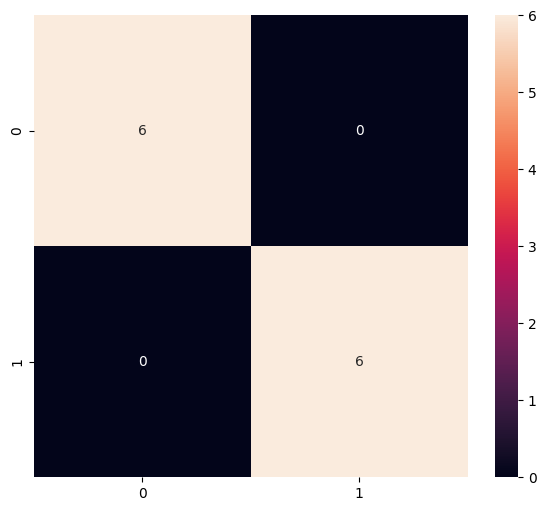

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, Y_pred)

In [14]:
import pickle

pickle.dump(model, open(model_save_path, 'wb'))

In [15]:
# Save as a model dedicated to inference
model.save_model(model_save_path)

c:\Users\zeins\anaconda3\envs\lsl\lib\site-packages\xgboost\core.py:160: UserWarning: [22:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [16]:
loaded_model = XGBClassifier()
loaded_model.load_model(model_save_path)

In [ ]:
loaded_model.score(X_test, y_test)